<a href="https://colab.research.google.com/github/joaovictordds/Prev_Acoes/blob/main/Preco_Acoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MODELAGEM DE PREÇO DE AÇÕES E PREVISÕES**

Construir um Modelo de Previsão de Preços de Ações

 - Esses modelos são usados para prever o preço de uma ação ou um índice para um período futuro.
 - baixar os preços das ações de qualquer uma das empresas listadas publicamente, no Yahoo Finance.
 - Esses dados são conhecidos como dados de séries temporais univariadas. Você pode usar modelos da classe ARIMA (AR, MA, ARMA, ARIMA) ou usar modelos de Suavização Exponencial.
 - Verificar os modelos de suavização exponencial.

### DADOS

In [ ]:
# Bibliotecas
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from seaborn import regression
import warnings
warnings.filterwarnings("ignore")
# Ferramentas gráficas
!pip install mplfinance
import mplfinance as mpf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# Símbolo da ação desejada
ticker = 'PETR3.SA'

# Obtenha os dados diários
dados = yf.download(ticker, start='2023-01-01', interval='1d')
dados.dropna()
dados.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-08,37.439999,37.480000,36.480000,36.759998,36.759998,11870400
2023-11-09,37.060001,37.810001,36.959999,37.540001,37.540001,14926800
2023-11-10,37.369999,37.750000,37.189999,37.419998,37.419998,6068100
2023-11-13,37.430000,38.270000,37.419998,38.259998,38.259998,9389000
2023-11-14,38.320000,38.689999,38.099998,38.570000,38.570000,9202400


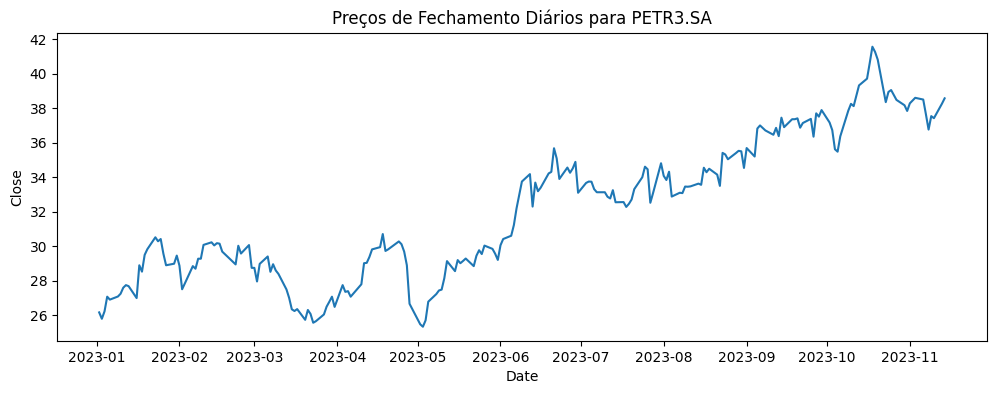

In [3]:
# Plotando o gráfico
plt.figure(figsize=(12, 4))
plt.title(f'Preços de Fechamento Diários para {ticker}')
plt.xlabel("Date")
plt.ylabel("Close")
plt.plot(dados["Close"])
plt.show();

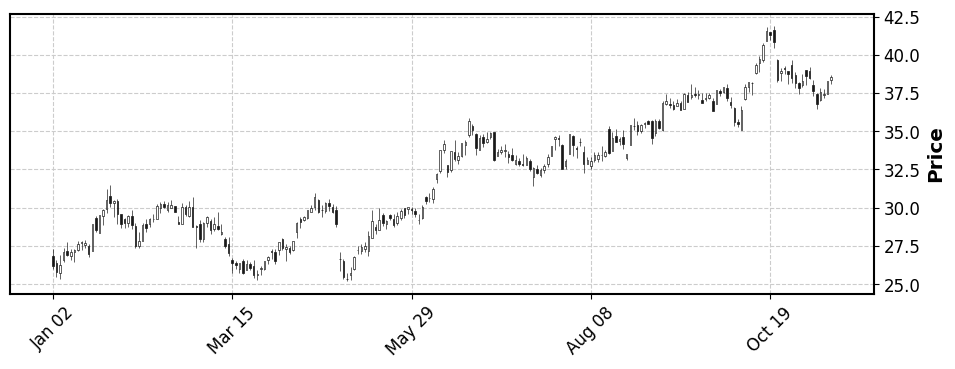

In [4]:
# Plot com as velas de preço
mpf.plot(dados, type = 'candle', figsize = (12,4), style='classic')

In [5]:
# Desindexando a coluna da data
dados = dados.reset_index()

In [6]:
fig1 =px.line(dados, x=dados['Date'], y=dados['Close'])
fig1.show()

In [7]:
# Adicionando figura com as velas de preço
fig2 = go.Figure(data=[go.Candlestick(x=dados.Date,
                open=dados['Open'],
                high=dados['High'],
                low=dados['Low'],
                close=dados['Close'],
                name="plot")])
fig2.show()

### ANALISE EXPLORATORIA

In [ ]:
# Coletando as informações disponiveis da companhia - income statement
petr = yf.Ticker("PETR3.SA")

In [ ]:
#Informações anulalizadas
petr.income_stmt

In [ ]:
# Declaração de renda trimestral
petr.quarterly_income_stmt

In [ ]:
# Balanço patrimonial (anualiz.)
petr.balance_sheet

In [ ]:
# Resultados trimestrais consolidados
petr.quarterly_balance_sheet.T

In [ ]:
petr.get_income_stmt()

In [ ]:
# Acionistas Majoritários
petr.major_holders

,0,1
0,50.26%,% of Shares Held by All Insider
1,20.16%,% of Shares Held by Institutions
2,40.53%,% of Float Held by Institutions
3,266,Number of Institutions Holding Shares


In [ ]:
# Datas de divid.
petr.earnings_dates

In [ ]:
dados = petr.quarterly_income_stmt.T
dados.to_csv('balancos_tri_petr3.csv')

***O LINK COM A ANALISE EXPLORATORIA ESTARÁ DISPONIBILIZADO NESTE REPOSITÓRIO***

### PRE PROCESSAMENTO

In [9]:
# Desindexando a coluna da data
dados = dados.reset_index()
# Passando-a para o formato data
dados['Date'] = pd.to_datetime(dados['Date'])
# carregando um df para os modelos
df = dados[['Date','Close']]
df['Preco'] = df['Close'].round(2)
df.drop('Close',axis=1, inplace=True)
df = df.dropna()  # Remover valores nulos
df.head()

,Date,Preco
0,2023-01-02,26.17
1,2023-01-03,25.80
2,2023-01-04,26.23
3,2023-01-05,27.08
4,2023-01-06,26.91


### ML - AutoTS

In [ ]:
import autots as AutoTS
# Modelando os dados
# selecionando as varaiveis e prevendo os dados dos prox 10 dias (demora)
model = AutoTS(forecast_length=10, frequency='infer', ensemble='simple', drop_data_older_than_periods=200)
model = model.fit(df, date_col='Date', value_col='Preco', id_col=None) #diminuir os parametros caso queira ir mais rapido

In [ ]:
# Modelo de Regressão Logística:
predicao = model.predict()
previsao = predicao.forecast
#previsao

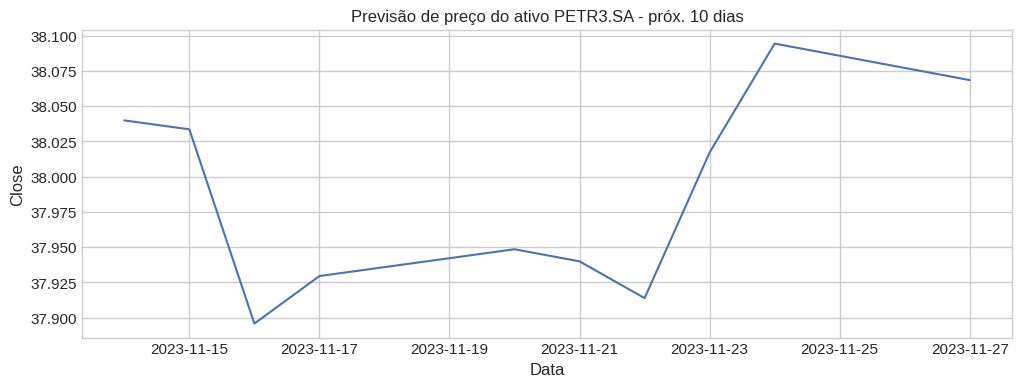

In [ ]:
# Gráfico com as previsões dos próximos 10 dias
plt.figure(figsize=(12, 4))
plt.title(f"Previsão de preço do ativo {ticker} - próx. 10 dias")
plt.xlabel("Data")
plt.ylabel("Close")
plt.plot(previsao["Preco"])
plt.show();

### ML - Facebook Prophet

In [ ]:
# Instale o Prophet diretamente do PyPI
!pip install pystan==2.19.1.1
!pip install prophet

In [ ]:
from prophet import Prophet

# Supondo que 'Date' está no formato de data e 'Preco' é a variável de destino
#df['Date'] = pd.to_datetime(df['Date'])
df = df.rename(columns={'Date': 'ds', 'Preco': 'y'})

# Crie uma instância do modelo Prophet e ajuste o modelo aos dados de treinamento
modelo = Prophet()
modelo.fit(df)

# Crie um dataframe com datas futuras para as previsões
prev = modelo.make_future_dataframe(periods=15)
# Faça as previsões
previsoes_futuras = modelo.predict(prev)


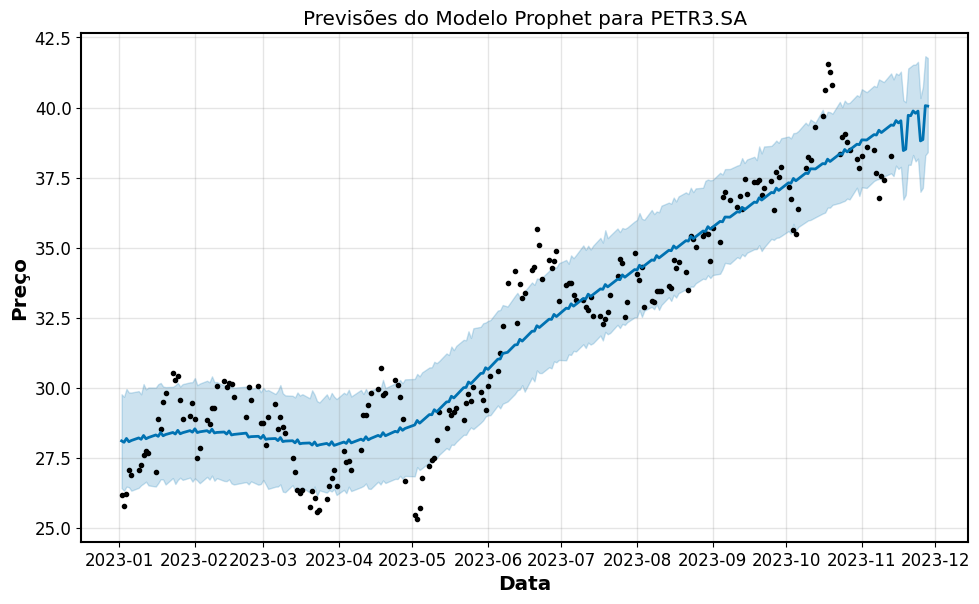

In [ ]:
# Visualizacao das previsões
fig = modelo.plot(previsoes_futuras)
plt.title(f'Previsões do Modelo Prophet para {ticker}')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

OUTRA FORMA GRÁFICA MESMO MODELO

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpputm9zg8/hcm0atp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpputm9zg8/j7vmce09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67574', 'data', 'file=/tmp/tmpputm9zg8/hcm0atp3.json', 'init=/tmp/tmpputm9zg8/j7vmce09.json', 'output', 'file=/tmp/tmpputm9zg8/prophet_modelhzw8_xkv/prophet_model-20231114130537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:05:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:05:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


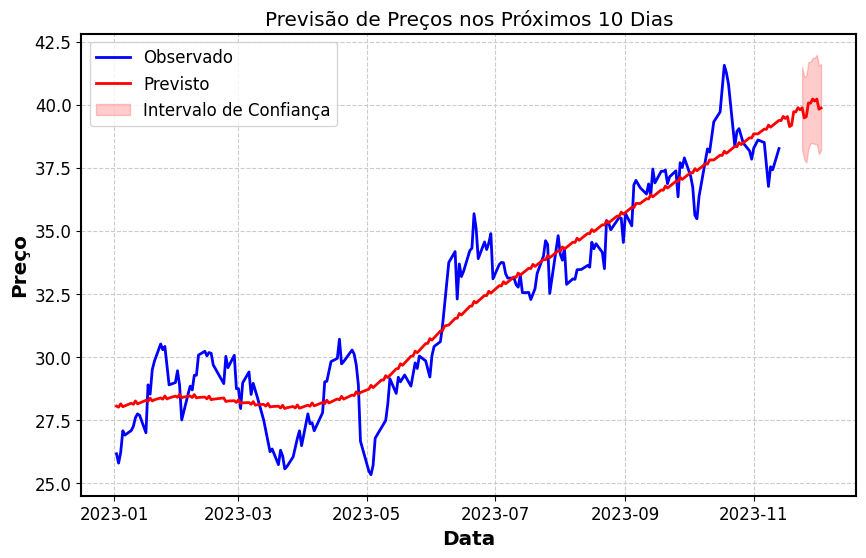

In [ ]:
# Crie e ajuste o modelo Prophet
modelo = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=0.1)
modelo.fit(df)

# Crie um dataframe com datas futuras para as previsões
futuro = modelo.make_future_dataframe(periods=20, freq='D')

# Faça as previsões
previsoes = modelo.predict(futuro)

# Exiba um gráfico com os valores observados e previstos
fig, ax = plt.subplots(figsize=(10, 6))

# Plot dos dados observados
ax.plot(df['ds'], df['y'], label='Observado', color='blue')

# Plot das previsões
ax.plot(previsoes['ds'], previsoes['yhat'], label='Previsto', color='red')

# Destaque os últimos 10 dias previstos
ax.fill_between(previsoes['ds'].tail(10), previsoes['yhat_lower'].tail(10), previsoes['yhat_upper'].tail(10), color='red', alpha=0.2, label='Intervalo de Confiança')

# Adicione rótulos e título
ax.set_xlabel('Data')
ax.set_ylabel('Preço')
ax.set_title('Previsão de Preços nos Próximos 10 Dias')
ax.legend()

# Exiba o gráfico
plt.show()

In [ ]:
# Exiba os valores previstos em um DataFrame
resultados = previsoes[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)
resultados = resultados.rename(columns={'ds': 'Data', 'yhat': 'Preco_Previsto', 'yhat_lower': 'Limite_Inferior', 'yhat_upper': 'Limite_Superior'})
resultados

,Data,Preco_Previsto,Limite_Inferior,Limite_Superior
227,2023-11-24,39.875332,38.207590,41.506101
228,2023-11-25,39.475819,37.831592,41.084629
229,2023-11-26,39.525055,37.707994,41.166880
230,2023-11-27,40.067047,38.262203,41.693847
231,2023-11-28,40.055817,38.471958,41.696593
232,2023-11-29,40.222757,38.471199,41.858439
233,2023-11-30,40.141079,38.441988,41.849807
234,2023-12-01,40.219986,38.437996,41.977688
235,2023-12-02,39.820473,38.036031,41.534660
236,2023-12-03,39.869710,38.192224,41.617519


### ML - Séries Temporais

In [43]:
df.tail(2)

,Date,Preco
216,2023-11-13,38.26
217,2023-11-14,38.57


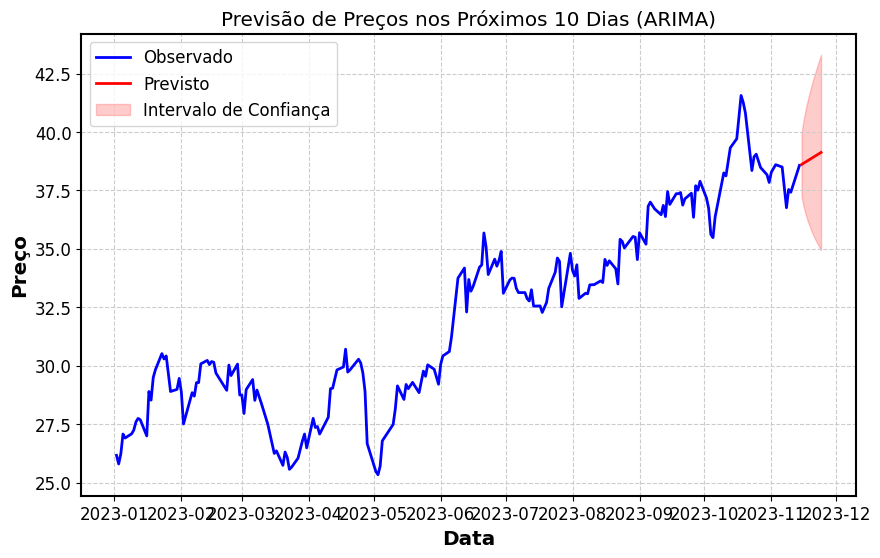

In [42]:
# Ajuste o modelo ARIMA
modelo_arima = ARIMA(df['Preco'], order=(1, 2, 1))  # Substitua p, d, q pelos valores adequados
resultado_arima = modelo_arima.fit()

# Crie um DataFrame para armazenar as datas futuras
datas_futuras = pd.date_range(start=dados['Date'].max(), periods=11, freq='D')[1:]

# Faça previsões para os próximos 10 dias
previsoes_arima = resultado_arima.get_forecast(steps=10)

# Extraia os resultados
resultados_arima = previsoes_arima.summary_frame()

# Atualize os índices das previsões
resultados_arima.index = datas_futuras

# Plote as observações e as previsões em um gráfico
plt.figure(figsize=(10, 6))

# Plot das observações
plt.plot(df['Date'], df['Preco'], label='Observado', color='blue')

# Plot das previsões
plt.plot(resultados_arima.index, resultados_arima['mean'], label='Previsto', color='red')

# Preencha a área entre os intervalos de confiança
plt.fill_between(resultados_arima.index, resultados_arima['mean_ci_lower'], resultados_arima['mean_ci_upper'], color='red', alpha=0.2, label='Intervalo de Confiança')

# Adicione rótulos e título
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Previsão de Preços nos Próximos 10 Dias (ARIMA)')
plt.legend()

# Exiba o gráfico
plt.show()


PREVISÕES PARA 20 DIAS UTILIZANDO OUTRA BIBLIOTECA GRAFICA PARA O PLOT.

In [41]:
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA

dias = 20 # não esquecer de alterar também o tamanho do 'datas_futuras' para novas observações

# Ajuste o modelo ARIMA
modelo_arima = ARIMA(df['Preco'], order=(1, 2, 1))  # Substitua p, d, q pelos valores adequados
resultado_arima = modelo_arima.fit()

# Crie um DataFrame para armazenar as datas futuras
datas_futuras = pd.date_range(start=dados['Date'].max(), periods=21, freq='D')[1:]

# Faça previsões para os próximos 10 dias
previsoes_arima = resultado_arima.get_forecast(steps=dias)

# Extraia os resultados
resultados_arima = previsoes_arima.summary_frame()

# Atualize os índices das previsões
resultados_arima.index = datas_futuras

# Crie o gráfico interativo usando plotly
fig = go.Figure()

# Adicione as observações
fig.add_trace(go.Scatter(x=df['Date'], y=df['Preco'], mode='lines', name='Observado', line=dict(color='blue')))

# Adicione as previsões
fig.add_trace(go.Scatter(x=datas_futuras, y=resultados_arima['mean'], mode='lines', name='Previsto', line=dict(color='red')))

# Adicione a área entre os intervalos de confiança
fig.add_trace(go.Scatter(x=datas_futuras, y=resultados_arima['mean_ci_upper'], fill=None, mode='lines', line=dict(color='red'), showlegend=False))
fig.add_trace(go.Scatter(x=datas_futuras, y=resultados_arima['mean_ci_lower'], fill='tonexty', mode='lines', line=dict(color='red'), name='Intervalo de Confiança'))

# Atualize o layout
fig.update_layout(title=f'Previsão de Preços nos Próximos {dias} dias para {ticker} (ARIMA)',
                  xaxis=dict(title='Data'),  yaxis=dict(title='Preço'))

# Exiba o gráfico
fig.show()


### DEPLOY

Acessar *github* ou diretamente pelo *streamlit*.